# Malária Cells

Dataset: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow.contrib.slim as slim
import random

In [2]:
%matplotlib inline

In [3]:
IMG_SIZE = (110, 110)
COLOR_CHANNELS = 3

### Data Sample

Sample of an uninfected cell image

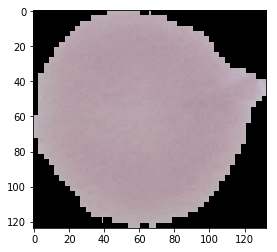

In [4]:
sample_uninfected = cv.imread('/media/miguel/Novo volume/cell_images/Uninfected/C179P140ThinF_IMG_20151127_153521_cell_155.png')
plt.imshow(sample_uninfected)

Sample of an parasitized cell image

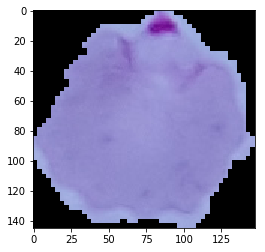

In [5]:
sample_parasitized = cv.imread('/media/miguel/Novo volume/cell_images/Parasitized/C99P60ThinF_IMG_20150918_142334_cell_36.png')
plt.imshow(sample_parasitized)

In [6]:
p_path = '/media/miguel/Novo volume/cell_images/Parasitized'
u_path = '/media/miguel/Novo volume/cell_images/Uninfected'

Load Data

In [7]:
import glob

In [8]:
p_names = glob.glob(p_path+"/*.png")
u_names = glob.glob(u_path+"/*.png")

In [9]:
def load_batch(batch_size):
    batch_x, batch_y = [], []
    for i in range(batch_size):
        if random.choice([True, False]): #Uninfected
            name, label = u_names[random.randrange(len(u_names))], [0,1]
        else: #Parasitized
            name, label = p_names[random.randrange(len(p_names))], [1,0]
        batch_x.append(cv.resize(cv.imread(name), IMG_SIZE))
        batch_y.append(label)
    return batch_x, batch_y

In [10]:
#load validation data
test_data, test_labels = [], []

#uninfected
for i in glob.glob('/media/miguel/Novo volume/cell_images/utest/*.png'):
    aux = cv.resize(cv.imread(i), IMG_SIZE)
    test_data.append(aux)
    test_labels.append([0,1])

#parasitized
for i in glob.glob('/media/miguel/Novo volume/cell_images/ptest/*.png'):
    aux = cv.resize(cv.imread(i), IMG_SIZE)
    test_data.append(aux)
    test_labels.append([1,0])

## Building the Model

In [11]:
model_input = tf.placeholder(tf.float32, shape=[None, IMG_SIZE[0], IMG_SIZE[0], COLOR_CHANNELS])
labels = tf.placeholder(tf.float32, shape=[None, 2])
learning_rate = tf.placeholder('float', [])

In [12]:
def vgg16(inputs):
  with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                      weights_regularizer=slim.l2_regularizer(0.0005)):
    net = slim.repeat(inputs, 2, slim.conv2d, 32, [7, 7], scope='conv1')
    print(net.shape)
    net = slim.max_pool2d(net, [2, 2], scope='pool1')
    print(net.shape)
    net = slim.repeat(net, 2, slim.conv2d, 64, [3, 3], scope='conv2')
    print(net.shape)
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    print(net.shape)
    net = slim.repeat(net, 3, slim.conv2d, 128, [3, 3], scope='conv3')
    print(net.shape)
    net = slim.max_pool2d(net, [2, 2], scope='pool5')
    print(net.shape)
    net = slim.flatten(net)
    print(net.shape)
    net = slim.fully_connected(net, 5096, scope='fc6')
    print(net.shape)
    net = slim.dropout(net, 0.5, scope='dropout6')
    print(net.shape)
    net = slim.fully_connected(net, 536, scope='fc7')
    print(net.shape)
    net = slim.dropout(net, 0.5, scope='dropout7')
    print(net.shape)
    net = slim.fully_connected(net, 2, activation_fn=tf.nn.sigmoid, scope='fc8')
    print(net.shape)
  return net

In [13]:
prediction = vgg16(model_input)

(?, 110, 110, 32)
(?, 55, 55, 32)
(?, 55, 55, 64)
(?, 27, 27, 64)
(?, 27, 27, 128)
(?, 13, 13, 128)
(?, 21632)
(?, 5096)
(?, 5096)
(?, 536)
(?, 536)
(?, 2)


In [14]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.squeeze(labels), logits=tf.squeeze(prediction)))
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [15]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [16]:
batch_size = 100
steps = 1000
rate = 3e-5

In [18]:
ac_list = []
lss_list = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size)
        feed = {model_input:batch_x, labels:batch_y, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%10 == 0:
            feed_validation = {model_input:test_data, labels:test_labels}
            plot_loss = sess.run(loss, feed_dict=feed_validation)
#             print(sess.run(prediction, feed_dict=feed_validation))
#             print(test_labels)
            matches = tf.equal(tf.argmax(prediction, 1), tf.argmax(test_labels, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            plot_accuracy = sess.run(acc, feed_dict=feed_validation)
            ac_list.append(plot_accuracy)
            lss_list.append(plot_loss)
        if i%100 == 0:
            print('Step: {}, Accuracy: {}, Loss: {}'.format(i, plot_accuracy, plot_loss))
            
    location = '../saved_models/modelo.ckpt'
    save_path = (saver.save(sess, location))
    print('model saved in', location)

Step: 0, Accuracy: 0.5, Loss: 0.6931468844413757
Step: 100, Accuracy: 0.6274510025978088, Loss: 0.640038788318634
Step: 200, Accuracy: 0.8333333134651184, Loss: 0.4773425757884979
Step: 300, Accuracy: 0.843137264251709, Loss: 0.46426403522491455
Step: 400, Accuracy: 0.9313725233078003, Loss: 0.38673219084739685
Step: 500, Accuracy: 0.9313725233078003, Loss: 0.382434219121933
Step: 600, Accuracy: 0.9215686321258545, Loss: 0.3917336165904999
Step: 700, Accuracy: 0.9117646813392639, Loss: 0.401801735162735
Step: 800, Accuracy: 0.9411764740943909, Loss: 0.373291015625
Step: 900, Accuracy: 0.9215686321258545, Loss: 0.39177849888801575
model saved in ../saved_models/modelo.ckpt


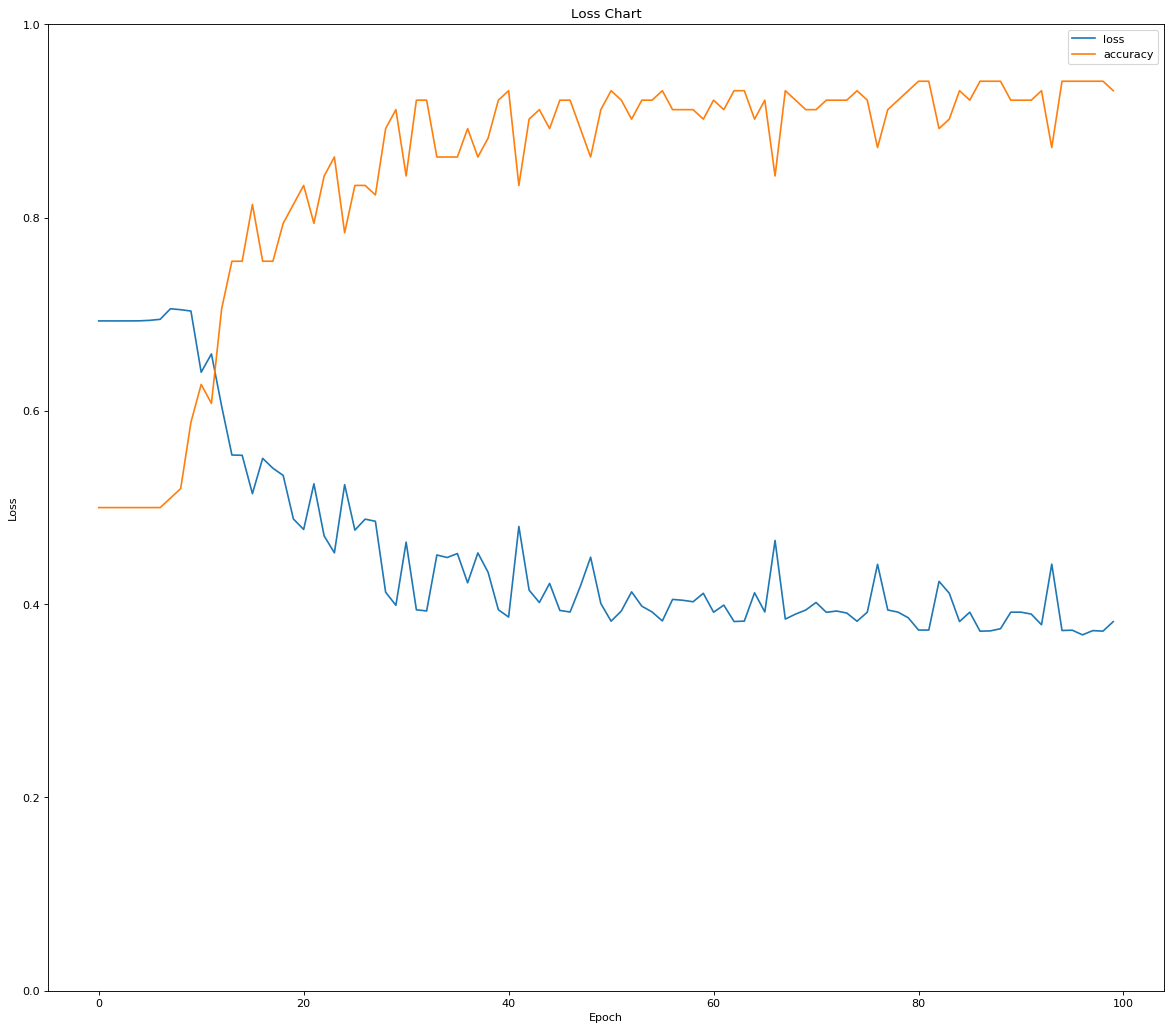

In [22]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.ylim(0,1)
plt.title('Loss Chart')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(lss_list, label="loss")
plt.plot(ac_list, label="accuracy")
plt.legend(loc='upper right')